In [1]:
import re

ruta_origen = "../data/Don Quijote de la Mancha.txt"
ruta_palabras = "../data/texto_limpio_palabras.txt"

# Cargar texto original
with open(ruta_origen, "r", encoding="utf-8") as f:
    texto = f.read()

# Preprocesamiento:
texto = texto.lower()  # Minúsculas
texto = re.sub(r"[^a-záéíóúñü\s]", " ", texto)  # Quitar signos
texto = re.sub(r"\s+", " ", texto).strip()  # Espacios limpios

# Guardar resultado
with open(ruta_palabras, "w", encoding="utf-8") as f:
    f.write(texto)

print(f"Archivo limpio por palabras guardado en: {ruta_palabras}")


Archivo limpio por palabras guardado en: ../data/texto_limpio_palabras.txt


In [2]:
ruta_sin_espacios = "../data/texto_limpio_palabras2.txt"

texto_sin_espacios = re.sub(r"[^a-záéíóúñü]", "", texto)  # Solo letras (sin espacios ni signos)

with open(ruta_sin_espacios, "w", encoding="utf-8") as f:
    f.write(texto_sin_espacios)

print(f"Archivo limpio SIN espacios guardado en: {ruta_sin_espacios}")


Archivo limpio SIN espacios guardado en: ../data/texto_limpio_palabras2.txt


[Ep 1] Train Loss: 6.8734, Acc: 0.2297 | Val Loss: 4.2838, Acc: 0.5430
>>> Mejor modelo guardado en ../modelos/mejor_modelo_lstm_palabras.pth
[Ep 2] Train Loss: 5.0477, Acc: 0.4353 | Val Loss: 2.7292, Acc: 0.7302
>>> Mejor modelo guardado en ../modelos/mejor_modelo_lstm_palabras.pth
[Ep 3] Train Loss: 4.2872, Acc: 0.5211 | Val Loss: 1.9920, Acc: 0.8079
>>> Mejor modelo guardado en ../modelos/mejor_modelo_lstm_palabras.pth
[Ep 4] Train Loss: 3.8665, Acc: 0.5662 | Val Loss: 1.5854, Acc: 0.8531
>>> Mejor modelo guardado en ../modelos/mejor_modelo_lstm_palabras.pth
[Ep 5] Train Loss: 3.6040, Acc: 0.5940 | Val Loss: 1.3208, Acc: 0.8781
>>> Mejor modelo guardado en ../modelos/mejor_modelo_lstm_palabras.pth
[Ep 6] Train Loss: 3.4233, Acc: 0.6141 | Val Loss: 1.2204, Acc: 0.8845
>>> Mejor modelo guardado en ../modelos/mejor_modelo_lstm_palabras.pth
[Ep 7] Train Loss: 3.2916, Acc: 0.6295 | Val Loss: 1.0991, Acc: 0.8962
>>> Mejor modelo guardado en ../modelos/mejor_modelo_lstm_palabras.pth
[Ep 8]

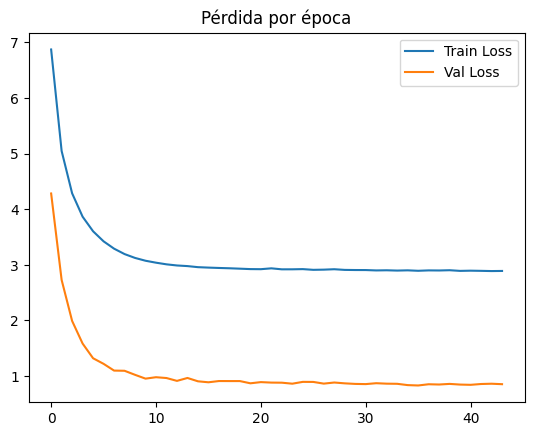

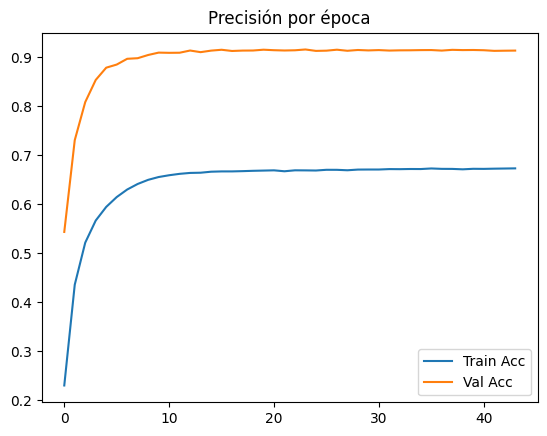

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Leer texto limpio por palabras ===
ruta_texto = "../data/texto_limpio_palabras.txt"
with open(ruta_texto, "r", encoding="utf-8") as f:
    palabras = f.read().split()

# Crear vocabulario
palabras_unicas = sorted(set(palabras))
word2idx = {w: i for i, w in enumerate(palabras_unicas)}
idx2word = {i: w for w, i in word2idx.items()}

# Codificar texto completo
texto_codificado = [word2idx[p] for p in palabras]

# Separar en entrenamiento y validación
texto_train, texto_valid = train_test_split(texto_codificado, test_size=0.15, random_state=42)

# === Definición del modelo LSTM ===
class ModeloLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x, estados):
        x = self.dropout(self.layernorm(self.embedding(x)))
        salida, estados = self.lstm(x, estados)
        salida = self.dropout_fc(self.fc(salida))
        return salida, estados

# === Función para batches aleatorios ===
def get_batch(data, seq_length, batch_size):
    ix = torch.randint(0, len(data) - seq_length - 1, (batch_size,))
    x_batch = torch.stack([torch.tensor(data[i:i+seq_length]) for i in ix])
    y_batch = torch.stack([torch.tensor(data[i+1:i+seq_length+1]) for i in ix])
    return x_batch.to(device), y_batch.to(device)

# === Hiperparámetros ===
vocab_size = len(palabras_unicas)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
seq_length = 20
batch_size = 128
epochs = 100
steps_per_epoch = 200
val_steps = 10
patience = 20

modelo_lstm = ModeloLSTM(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
optimizer = torch.optim.AdamW(modelo_lstm.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Early stopping y métricas
mejor_accuracy = 0.0
patience_counter = 0
ruta_checkpoint = "../modelos/mejor_modelo_lstm_palabras.pth"
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# === Entrenamiento ===
for epoch in range(1, epochs + 1):
    modelo_lstm.train()
    train_loss_total = 0
    train_acc_total = 0

    for _ in range(steps_per_epoch):
        x_batch, y_batch = get_batch(texto_train, seq_length, batch_size)
        h0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
        c0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

        optimizer.zero_grad()
        output, _ = modelo_lstm(x_batch, (h0.detach(), c0.detach()))
        output = output.view(-1, vocab_size)
        y_batch = y_batch.view(-1)

        loss = criterion(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelo_lstm.parameters(), max_norm=1.5)
        optimizer.step()

        _, pred = torch.max(output, dim=1)
        acc = (pred == y_batch).float().mean().item()
        train_loss_total += loss.item()
        train_acc_total += acc

    avg_train_loss = train_loss_total / steps_per_epoch
    avg_train_acc = train_acc_total / steps_per_epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    modelo_lstm.eval()
    val_loss_total = 0
    val_acc_total = 0

    with torch.no_grad():
        for _ in range(val_steps):
            x_val, y_val = get_batch(texto_valid, seq_length, batch_size)
            h0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)
            c0 = torch.zeros(num_layers * 2, batch_size, hidden_dim).to(device)

            output_val, _ = modelo_lstm(x_val, (h0, c0))
            output_val = output_val.view(-1, vocab_size)
            y_val = y_val.view(-1)

            val_loss = criterion(output_val, y_val)
            _, pred_val = torch.max(output_val, dim=1)
            val_acc = (pred_val == y_val).float().mean().item()

            val_loss_total += val_loss.item()
            val_acc_total += val_acc

    avg_val_loss = val_loss_total / val_steps
    avg_val_acc = val_acc_total / val_steps
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"[Ep {epoch}] Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

    if avg_val_acc > mejor_accuracy:
        mejor_accuracy = avg_val_acc
        patience_counter = 0
        torch.save(modelo_lstm.state_dict(), ruta_checkpoint)
        print(f">>> Mejor modelo guardado en {ruta_checkpoint}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f">>> Early stopping en época {epoch}")
            break

print(f"Mejor precisión de validación: {mejor_accuracy:.4f}")

# === Gráficas ===
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Pérdida por época")
plt.show()

plt.figure()
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.legend()
plt.title("Precisión por época")
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

# === Configuración ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ruta_modelo = "../modelos/mejor_modelo_lstm_palabras.pth"
archivo_tokens = "../data/texto_limpio_palabras.txt"
temperatura = 1.2
top_k = 10
seq_length = 10
num_sugerencias = 3

# === Cargar texto y tokenizar ===
with open(archivo_tokens, "r", encoding="utf-8") as f:
    tokens = f.read().split()

vocabulario = sorted(set(tokens))
token_to_id = {w: i for i, w in enumerate(vocabulario)}
id_to_token = {i: w for w, i in token_to_id.items()}
vocab_size = len(vocabulario)

# === Modelo ===
class ModeloLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers,
            dropout=0.3, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x, estados=None):
        x = self.dropout(self.layernorm(self.embedding(x)))
        salida, estados = self.lstm(x, estados)
        salida = self.dropout_fc(self.fc(salida))
        return salida, estados

# === Cargar modelo ===
modelo = ModeloLSTM(vocab_size).to(device)
modelo.load_state_dict(torch.load(ruta_modelo, map_location=device))
modelo.eval()

# === Widgets base ===
entrada_texto = widgets.Text(
    value='',
    placeholder='Escribe una frase',
    description='Frase:',
    layout=widgets.Layout(width='80%')
)

boton_sugerir = widgets.Button(description="Sugerir palabras", button_style='info')
salida = widgets.Output(layout={'border': '1px solid black', 'width': '100%', 'overflow_x': 'auto'})
contenedor_sugerencias = widgets.HBox([])

# === Función de sugerencia ===
def sugerir_palabras(b):
    frase = entrada_texto.value.lower().strip()
    with salida:
        clear_output()
    contenedor_sugerencias.children = []

    if not frase:
        with salida:
            print("Por favor ingresa una frase válida.")
        return

    entrada_ids = [token_to_id.get(w, 0) for w in frase.split()]
    entrada_ids = entrada_ids[-seq_length:]
    while len(entrada_ids) < seq_length:
        entrada_ids.insert(0, 0)

    input_tensor = torch.tensor([entrada_ids], dtype=torch.long).to(device)

    with torch.no_grad():
        salida_logits, _ = modelo(input_tensor)
        logits = salida_logits[:, -1, :] / temperatura
        probas = F.softmax(logits, dim=-1).squeeze()
        top_probs, top_indices = torch.topk(probas, top_k)
        sugerencias = [id_to_token[idx.item()] for idx in top_indices[:num_sugerencias]]

    # Crear botones de sugerencia
    botones = []
    for palabra in sugerencias:
        boton = widgets.Button(description=palabra, button_style='success')
        def agregar_palabra(b, palabra=palabra):
            entrada_texto.value = (entrada_texto.value + " " + palabra).strip()
        boton.on_click(agregar_palabra)
        botones.append(boton)

    contenedor_sugerencias.children = botones
    with salida:
        display(Markdown("**Haz clic en una sugerencia para continuar la frase.**"))

# === Conectar botón y mostrar interfaz ===
boton_sugerir.on_click(sugerir_palabras)
display(widgets.VBox([entrada_texto, boton_sugerir, contenedor_sugerencias, salida]))
